In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.weightstats import ttost_ind
import matplotlib.pylab as pylab
from collections import defaultdict
from sklearn.decomposition import PCA
from itertools import chain, combinations
#from statannotations.Annotator import Annotator
%matplotlib inline
np.random.seed(22)

In [2]:
#!pip install statannotations

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
import seaborn as sns
sns.set_palette("binary")

BOXPROPS = {
    'boxprops':{'facecolor':'white', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'color':'white',
    "linewidth":0.8
}

BOXPROPS2 = {
    'boxprops':{'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    #'color':'white',
    "linewidth":0.8
}

meanlineprops = dict(linestyle='--', linewidth=1, color='black')

In [4]:
# load pre-processed data
data = pd.read_csv("study1data.csv",index_col=0)

In [7]:
# moved Q5 to index 2 in preprocessing

arguments = [
    "Abortion is morally unacceptable, and it goes against the qualities and ethics that make this country great.",
    "More guns equals less crime. Just because crimes were committed with guns it does not mean control would work.",
    "The media coverage on pollution affecting global warming on a grand scale is a scam lead by liberals such as Al Gore, Michael Moore and the liberal media.",
    "The minimum wage increasing will allow more people to have more money, stimulating the economy and helping citizens who are currently in poverty reach out of it, take a foothold, and stay in the middle class.",
    "A just society’s goal should be to protect and further the wellbeing of its people (and, indeed, of all people, since being just requires a lack of bias toward or against other societies). Killing people as a form of punishment does not, as a rule, serve the interest of such a society.",
    "CO2 is the largest contribution to global warming, at 72% of greenhouse gas emissions, and greenhouse gas emissions are a major contributor to global warming."
]

topics = [
    "abortion",
    "gun control",
    "global warming",
    "minimum wage",
    "death penalty",
    "global warming"
]

argument_type = [
    "Republican",
    "Republican",
    "Republican",
    "Democrat",
    "Democrat",
    "Democrat"
]

#firsttask_columns = ['Q1_1', 'Q2_1','Q5_1','Q3_1', 
#                     'Q4_1', 'Q6_1']

#lower_bound_columns =  ['Q1_2_3', 'Q2_2_1', 'Q5_2_1','Q3_2_1',
#                        'Q4_2_1',  'Q6_2_1']

#upper_bound_columns = ['Q1_2_4',  'Q2_2_2', 'Q5_2_2','Q3_2_2',
#                       'Q4_2_2', 'Q6_2_2']

#midpoint_columns = ['Q1_midpoint',
#       'Q2_midpoint', 'Q5_midpoint','Q3_midpoint', 'Q4_midpoint',
#       'Q6_midpoint']

firsttask_columns = ['Q1_1', 'Q2_1','Q3_1', 
                     'Q4_1', 'Q5_1','Q6_1']

lower_bound_columns =  ['Q1_2_3', 'Q2_2_1', 'Q3_2_1',
                        'Q4_2_1', 'Q5_2_1', 'Q6_2_1']

upper_bound_columns = ['Q1_2_4',  'Q2_2_2','Q3_2_2',
                       'Q4_2_2', 'Q5_2_2', 'Q6_2_2']

midpoint_columns = ['Q1_midpoint',
       'Q2_midpoint','Q3_midpoint', 'Q4_midpoint',
        'Q5_midpoint',
       'Q6_midpoint']



# Descriptive stats

In [8]:

data.polAffil.value_counts()

Democrat      641
Republican    619
Name: polAffil, dtype: int64

In [11]:
# Condition 0 = No incentives
# Condition 1 = Incentives
data.Condition.value_counts()

1.0    644
0.0    616
Name: Condition, dtype: int64

In [9]:
data[data.polAffil=="Democrat"].Condition.value_counts()

1.0    325
0.0    316
Name: Condition, dtype: int64

In [10]:
data[data.polAffil=="Republican"].Condition.value_counts()

1.0    319
0.0    300
Name: Condition, dtype: int64

In [12]:
print(len(data[data.polAffil=="Republican"]))
print(len(data[data.polAffil=="Democrat"]))
print(len(data))
print(len(data.ID.unique()))

619
641
1260
1260


In [13]:
data.age.mean()

38.88174603174603

In [15]:
data.gender.value_counts()

Female                       621
Male                         619
Non-binary / third gender     19
Prefer not to say              1
Name: gender, dtype: int64

# Per-statement analysis

For each statement:

Between-participant analysis done with one-sided Mann-Whitney U-tests. These are between opinions of Democrats and Republicans in task 1, and also between their midpoints (beliefs) of task 2, currently without distinguishing between conditions (incentivized or not).

Within-participant analysis done with two-sided Wilcoxon signed-rank tests, i.e. 1) between Democrats opinions and their midpoint beliefs, and 2) between Republicans opinions and their midpoint beliefs. This is done both with and without distinguishing between the two conditions (incentivized or not).

In [16]:

sum1 = []
sum2 = []
sum2_C = []
hyptesting = []

for indel in range(6):
    d = {}
    db = {}
    dbC = {}
    dh = {}
   
    arg = arguments[indel]
    d["statement"] = arg
    d["statement pol"] = argument_type[indel]
    db["statement"] = arg
    db["statement pol"] = argument_type[indel]
    dbC["statement"] = arg
    dbC["statement pol"] = argument_type[indel]
    if argument_type[indel]=="Republican":
        d["Hypothesis"] = "D<R"
        db["Hypothesis"] = "D<R"
        dbC["Hypothesis"] = "D<R"
        dh["Hypothesis"] = "D<R"
        mann_task1 = stats.mannwhitneyu(data[data.polAffil=="Democrat"][firsttask_columns[indel]],
                                    data[data.polAffil=="Republican"][firsttask_columns[indel]]
                                    ,alternative="less")
        mann_task2 = stats.mannwhitneyu(data[data.polAffil=="Democrat"][midpoint_columns[indel]],
                                    data[data.polAffil=="Republican"][midpoint_columns[indel]],
                                    alternative="less")
        
    
    else:
        d["Hypothesis"] = "D>R"
        db["Hypothesis"] = "D>R"
        dbC["Hypothesis"] = "D>R"
        dh["Hypothesis"] = "D>R"
        mann_task1 = stats.mannwhitneyu(data[data.polAffil=="Democrat"][firsttask_columns[indel]],
                                    data[data.polAffil=="Republican"][firsttask_columns[indel]]
                                    ,alternative="greater")
        mann_task2 = stats.mannwhitneyu(data[data.polAffil=="Democrat"][midpoint_columns[indel]],
                                    data[data.polAffil=="Republican"][midpoint_columns[indel]],
                                    alternative="greater")
        
    D_mean = data[data.polAffil=="Democrat"][firsttask_columns[indel]].mean()
    R_mean = data[data.polAffil=="Republican"][firsttask_columns[indel]].mean()
    D_SD = data[data.polAffil=="Democrat"][firsttask_columns[indel]].std()
    R_SD = data[data.polAffil=="Republican"][firsttask_columns[indel]].std()
    pop_mean = data[firsttask_columns[indel]].mean()
    
    d["Opinion Pop M"] = np.round(pop_mean,4)
    d["Opinion D M (SD)"] = str(np.round(D_mean,4))+" ("+str(np.round(D_SD,4))+")"
    d["Opinion R M (SD)"] = str(np.round(R_mean,4))+" ("+str(np.round(R_SD,4))+")"
    dh["Opinion Mann-Whitney"] = np.round(mann_task1[1],4)
    
    D_belief = data[data.polAffil=="Democrat"][midpoint_columns[indel]]
    R_belief = data[data.polAffil=="Republican"][midpoint_columns[indel]]
    db["Belief D M (SD)"] = str(np.round(D_belief.mean(),4))+" ("+str(np.round(D_belief.std(),4))+")"
    db["Belief R M (SD)"] = str(np.round(R_belief.mean(),4))+" ("+str(np.round(R_belief.std(),4))+")"
    dh["Belief Mann-Whitney"] = np.round(mann_task2[1],4)
    
    
    
    wilcox_D = stats.wilcoxon(data[data.polAffil=="Democrat"][firsttask_columns[indel]],data[data.polAffil=="Democrat"][midpoint_columns[indel]])
    wilcox_R = stats.wilcoxon(data[data.polAffil=="Republican"][firsttask_columns[indel]],data[data.polAffil=="Republican"][midpoint_columns[indel]])
    dh["D Wilcoxon"] = np.round(wilcox_D[1],4)
    dh["R Wilcoxon"] = np.round(wilcox_R[1],4)
    
    
    
    for c in [0,1]:
        
        
        D_first_curr_condition = data[(data.polAffil=="Democrat")&(data.Condition==c)][firsttask_columns[indel]].values
        
        D_mid = data[(data.polAffil=="Democrat")&(data.Condition==c)][midpoint_columns[indel]].values
        dbC["Belief C{} D M (SD)".format(c)] = str(np.round(D_mid.mean(),4))+" ("+str(np.round(D_mid.std(),4))+")"
        wilcoxon_D_C = stats.wilcoxon(D_first_curr_condition,D_mid)
        dh["D C{} Wilcoxon".format(c)] = np.round(wilcoxon_D_C[1],4)
        
        R_first_curr_condition = data[(data.polAffil=="Republican")&(data.Condition==c)][firsttask_columns[indel]].values
        
        R_mid = data[(data.polAffil=="Republican")&(data.Condition==c)][midpoint_columns[indel]].values
        dbC["Belief C{} R M (SD)".format(c)] = str(np.round(R_mid.mean(),4))+" ("+str(np.round(R_mid.std(),4))+")"
        wilcoxon_R_C = stats.wilcoxon(R_first_curr_condition,R_mid)
        dh["R C{} Wilcoxon".format(c)] = np.round(wilcoxon_R_C[1],4)
        
        
        
        # two-sided at the moment, wihthin the conditions
        R_within = stats.wilcoxon(R_first_curr_condition,R_mid)[1]
        D_within = stats.wilcoxon(D_first_curr_condition,D_mid)[1]
        
        
    
    sum1.append(d)
    sum2.append(db)
    sum2_C.append(dbC)
    hyptesting.append(dh)
    

opinion_sumstat = pd.DataFrame(sum1)
belief_sumstat = pd.DataFrame(sum2)
belief_sumstat_conditions = pd.DataFrame(sum2_C)
test_sum = pd.DataFrame(hyptesting)

    
opinion_sumstat        

,statement,statement pol,Hypothesis,Opinion Pop M,Opinion D M (SD),Opinion R M (SD)
0,"Abortion is morally unacceptable, and it goes ...",Republican,D<R,0.4958,0.4322 (0.4079),0.5618 (0.381)
1,More guns equals less crime. Just because crim...,Republican,D<R,0.5083,0.4548 (0.3847),0.5638 (0.3613)
2,The media coverage on pollution affecting glob...,Republican,D<R,0.3585,0.3069 (0.3752),0.412 (0.3869)
3,The minimum wage increasing will allow more pe...,Democrat,D>R,0.7014,0.7573 (0.3092),0.6435 (0.3438)
4,A just society’s goal should be to protect and...,Democrat,D>R,0.6395,0.6811 (0.3351),0.5965 (0.349)
5,CO2 is the largest contribution to global warm...,Democrat,D>R,0.6260,0.6385 (0.3811),0.613 (0.3605)


In [17]:
belief_sumstat

,statement,statement pol,Hypothesis,Belief D M (SD),Belief R M (SD)
0,"Abortion is morally unacceptable, and it goes ...",Republican,D<R,0.4845 (0.184),0.5129 (0.1908)
1,More guns equals less crime. Just because crim...,Republican,D<R,0.4819 (0.1763),0.497 (0.1819)
2,The media coverage on pollution affecting glob...,Republican,D<R,0.4247 (0.1937),0.4499 (0.2061)
3,The minimum wage increasing will allow more pe...,Democrat,D>R,0.6034 (0.1652),0.5692 (0.1778)
4,A just society’s goal should be to protect and...,Democrat,D>R,0.5676 (0.168),0.5552 (0.1817)
5,CO2 is the largest contribution to global warm...,Democrat,D>R,0.5619 (0.1841),0.5763 (0.1917)


In [18]:
belief_sumstat_conditions

,statement,statement pol,Hypothesis,Belief C0 D M (SD),Belief C0 R M (SD),Belief C1 D M (SD),Belief C1 R M (SD)
0,"Abortion is morally unacceptable, and it goes ...",Republican,D<R,0.4764 (0.1824),0.5126 (0.1771),0.4924 (0.1849),0.5133 (0.2025)
1,More guns equals less crime. Just because crim...,Republican,D<R,0.491 (0.1673),0.4996 (0.1744),0.4731 (0.184),0.4945 (0.1884)
2,The media coverage on pollution affecting glob...,Republican,D<R,0.4169 (0.1895),0.4566 (0.1974),0.4323 (0.1972),0.4437 (0.2135)
3,The minimum wage increasing will allow more pe...,Democrat,D>R,0.5969 (0.1615),0.5615 (0.174),0.6098 (0.1682),0.5765 (0.1806)
4,A just society’s goal should be to protect and...,Democrat,D>R,0.5608 (0.1597),0.5449 (0.1806),0.5741 (0.1752),0.5649 (0.1819)
5,CO2 is the largest contribution to global warm...,Democrat,D>R,0.5585 (0.1802),0.5713 (0.181),0.5653 (0.1874),0.581 (0.2008)


In [19]:
test_sum

,Hypothesis,Opinion Mann-Whitney,Belief Mann-Whitney,D Wilcoxon,R Wilcoxon,D C0 Wilcoxon,R C0 Wilcoxon,D C1 Wilcoxon,R C1 Wilcoxon
0,D<R,0.0000,0.0012,0.0002,0.0007,0.0014,0.1052,0.0347,0.0016
1,D<R,0.0000,0.0418,0.0354,0.0000,0.0164,0.0009,0.5444,0.0002
2,D<R,0.0000,0.0106,0.0000,0.0010,0.0000,0.0001,0.0000,0.4297
3,D>R,0.0000,0.0003,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000
4,D>R,0.0000,0.1324,0.0000,0.0005,0.0000,0.0020,0.0000,0.0562
5,D>R,0.0212,0.8288,0.0000,0.0005,0.0000,0.0002,0.0000,0.2173


In [21]:
# Make Latex table:

with pd.option_context("max_colwidth", 1000):
    #print(opinion_sumstat.style.to_latex())
    print(opinion_sumstat.to_latex())

\begin{tabular}{llllrll}
\toprule
{} &                                                                                                                                                                                                                                                                                       statement & statement pol & Hypothesis &  Opinion Pop M & Opinion D M (SD) & Opinion R M (SD) \\
\midrule
0 &                                                                                                                                                                                    Abortion is morally unacceptable, and it goes against the qualities and ethics that make this country great. &    Republican &        D<R &         0.4958 &  0.4322 (0.4079) &   0.5618 (0.381) \\
1 &                                                                                                                                                                                  More guns equals 

## Looking over all D and R participants' mean responses (rather than seperate sentences) 

In [52]:
Dargs_toinclude = ['Q4_1','Q5_1','Q6_1']
Rargs_toinclude = ['Q1_1', 'Q2_1', 'Q3_1']

Dargs_beliefs_toinclude = ['Q4_midpoint','Q5_midpoint','Q6_midpoint']
Rargs_beliefs_toinclude = ['Q1_midpoint','Q2_midpoint','Q3_midpoint']

def mean_stats(Dargs_toinclude,Rargs_toinclude,Dargs_beliefs_toinclude,Rargs_beliefs_toinclude):

    # participants' mean opinion for D arguments
    demargs_D_M = data[data.polAffil=="Democrat"][Dargs_toinclude].mean(axis=1).values
    print(demargs_D_M.mean())
    demargs_R_M = data[data.polAffil=="Republican"][Dargs_toinclude].mean(axis=1).values
    print(demargs_R_M.mean())
    print(stats.mannwhitneyu(demargs_D_M, demargs_R_M, alternative="greater"))

    # participants' mean belief for D arguments
    demargs_belief_D_M = data[data.polAffil=="Democrat"][Dargs_beliefs_toinclude].mean(axis=1).values
    print(demargs_belief_D_M.mean())
    demargs_belief_R_M = data[data.polAffil=="Republican"][Dargs_beliefs_toinclude].mean(axis=1).values
    print(demargs_belief_R_M.mean())
    print(stats.mannwhitneyu(demargs_belief_D_M, demargs_belief_R_M, alternative="greater"))


    # participants' mean opinion for R arguments
    repargs_D_M = data[data.polAffil=="Democrat"][Rargs_toinclude].mean(axis=1).values
    print(repargs_D_M.mean())
    repargs_R_M = data[data.polAffil=="Republican"][Rargs_toinclude].mean(axis=1).values
    print(repargs_R_M.mean())
    print(stats.mannwhitneyu(repargs_D_M, repargs_R_M, alternative="less"))
    
    # participants' mean belief for R arguments
    repargs_belief_D_M = data[data.polAffil=="Democrat"][Rargs_beliefs_toinclude].mean(axis=1).values
    print(repargs_belief_D_M.mean())
    repargs_belief_R_M = data[data.polAffil=="Republican"][Rargs_beliefs_toinclude].mean(axis=1).values
    print(repargs_belief_R_M.mean())
    print(stats.mannwhitneyu(repargs_belief_D_M, repargs_belief_R_M, alternative="less"))

    
    d1 = {"Statement pol": "Democrat",
        "Opinion D M (SD)": str(np.round(demargs_D_M.mean(),4))+" ("+str(np.round(demargs_D_M.std(),4))+")",
        "Opinion R M (SD)": str(np.round(demargs_R_M.mean(),4))+" ("+str(np.round(demargs_R_M.std(),4))+")",
        "Opinion Mann-Whitney": stats.mannwhitneyu(demargs_D_M, demargs_R_M, alternative="greater")[1],
        "Belief D M (SD)": str(np.round(demargs_belief_D_M.mean(),4))+" ("+str(np.round(demargs_belief_D_M.std(),4))+")",
        "Belief R M (SD)": str(np.round(demargs_belief_R_M.mean(),4))+" ("+str(np.round(demargs_belief_R_M.std(),4))+")",
        "Belief Mann-Whitney": stats.mannwhitneyu(demargs_belief_D_M, demargs_belief_R_M, alternative="greater")[1]
     }

    d2 = {"Statement pol": "Republican",
        "Opinion D M (SD)": str(np.round(repargs_D_M.mean(),4))+" ("+str(np.round(repargs_D_M.std(),4))+")",
        "Opinion R M (SD)": str(np.round(repargs_R_M.mean(),4))+" ("+str(np.round(repargs_R_M.std(),4))+")",
        "Opinion Mann-Whitney": stats.mannwhitneyu(repargs_D_M, repargs_R_M, alternative="less")[1],
        "Belief D M (SD)": str(np.round(repargs_belief_D_M.mean(),4))+" ("+str(np.round(repargs_belief_D_M.std(),4))+")",
        "Belief R M (SD)": str(np.round(repargs_belief_R_M.mean(),4))+" ("+str(np.round(repargs_belief_R_M.std(),4))+")",
        "Belief Mann-Whitney": stats.mannwhitneyu(repargs_belief_D_M, repargs_belief_R_M, alternative="less")[1]
     }

    
    return pd.DataFrame([d1,d2])

mean_stats(Dargs_toinclude,Rargs_toinclude,Dargs_beliefs_toinclude,Rargs_beliefs_toinclude)

0.6923088923556941
0.6176628971459344
MannwhitneyuResult(statistic=237503.5, pvalue=6.83071826738417e-10)
0.577646905876235
0.5669197630586967
MannwhitneyuResult(statistic=209629.0, pvalue=0.0408775850563722)
0.3979511180447218
0.512509423801831
MannwhitneyuResult(statistic=155525.5, pvalue=1.553004577713871e-11)
0.46370774830993244
0.4866155088852988
MannwhitneyuResult(statistic=180107.5, pvalue=0.0023182427788265435)


,Statement pol,Opinion D M (SD),Opinion R M (SD),Opinion Mann-Whitney,Belief D M (SD),Belief R M (SD),Belief Mann-Whitney
0,Democrat,0.6923 (0.2016),0.6177 (0.2164),6.830718e-10,0.5776 (0.1147),0.5669 (0.1218),0.040878
1,Republican,0.398 (0.3219),0.5125 (0.2984),1.553005e-11,0.4637 (0.1444),0.4866 (0.1561),0.002318


In [53]:
mean_stats(Dargs_toinclude[:2],Rargs_toinclude[:2],Dargs_beliefs_toinclude[:2],Rargs_beliefs_toinclude[:2])

0.7192277691107644
0.619983844911147
MannwhitneyuResult(statistic=237635.0, pvalue=5.577323915139973e-10)
0.5854992199687987
0.5622374798061389
MannwhitneyuResult(statistic=217638.0, pvalue=0.001436513200882607)
0.4434711388455538
0.5627786752827141
MannwhitneyuResult(statistic=158296.0, pvalue=2.523457708030944e-10)
0.4832020280811233
0.5049555735056542
MannwhitneyuResult(statistic=179304.5, pvalue=0.001559657164721796)


,Statement pol,Opinion D M (SD),Opinion R M (SD),Opinion Mann-Whitney,Belief D M (SD),Belief R M (SD),Belief Mann-Whitney
0,Democrat,0.7192 (0.2557),0.62 (0.2867),5.577324e-10,0.5855 (0.141),0.5622 (0.1485),0.001437
1,Republican,0.4435 (0.3505),0.5628 (0.3126),2.523458e-10,0.4832 (0.1531),0.505 (0.1622),0.001560


## Does the certainty (the width of the intervals) affect the differences?

In [115]:
tempdata = data[data.width_median<0.20] # edit if looking at all data instead

temp = tempdata.melt(id_vars=["polAffil","Condition"],value_vars=firsttask_columns+midpoint_columns)


temp["Task"] = ["Belief" if "midpoint" in i else "Opinion" for i in temp.variable]
temp["Statement"] = ["S"+s[1] for s in temp.variable]

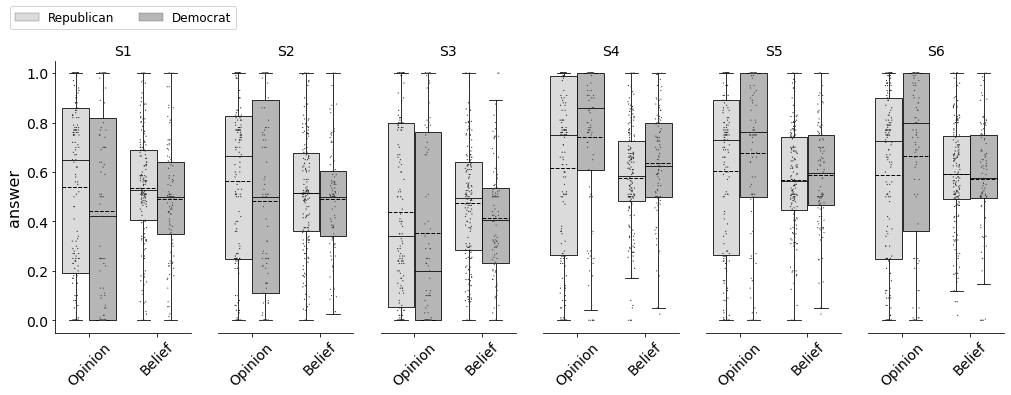

In [116]:

fig, axes = plt.subplots(ncols=6, sharex=True, sharey=True, figsize=(17,5))
for ax, (n,grp) in zip(axes, temp.groupby("Statement")):
    sns.boxplot(x="Task", y="value", hue="polAffil", 
                data=grp, 
                ax=ax,
                showfliers=False,
                showmeans=True,
                meanline=True,
                meanprops=meanlineprops,
                **BOXPROPS2)
    sns.stripplot(x="Task", y="value", hue="polAffil",
                  dodge=True,
                  data=grp, 
                  ax=ax, 
                  color=".25",
                  size=1.2)
    ax.set_title(n)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set(ylabel = "answer")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    handles, labels = ax.get_legend_handles_labels()
    
axes[1].spines['left'].set_visible(False)
axes[2].spines['left'].set_visible(False)
axes[3].spines['left'].set_visible(False)
axes[4].spines['left'].set_visible(False)
axes[5].spines['left'].set_visible(False)
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
axes[3].get_legend().remove()
axes[4].get_legend().remove()
axes[5].get_legend().remove()
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
axes[4].get_yaxis().set_visible(False)
axes[5].get_yaxis().set_visible(False)
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
axes[3].set_xlabel("")
axes[4].set_xlabel("")
axes[5].set_xlabel("")

plt.legend(handles[0:2], labels[0:2],bbox_to_anchor=(-5.5, 1.2), loc="upper center", borderaxespad=0.,frameon=True,ncol=2);
#plt.legend(frameon=True)
#plt.tight_layout()
#plt.savefig("boxplot_veryshortintervals.pdf",bbox_inches='tight')

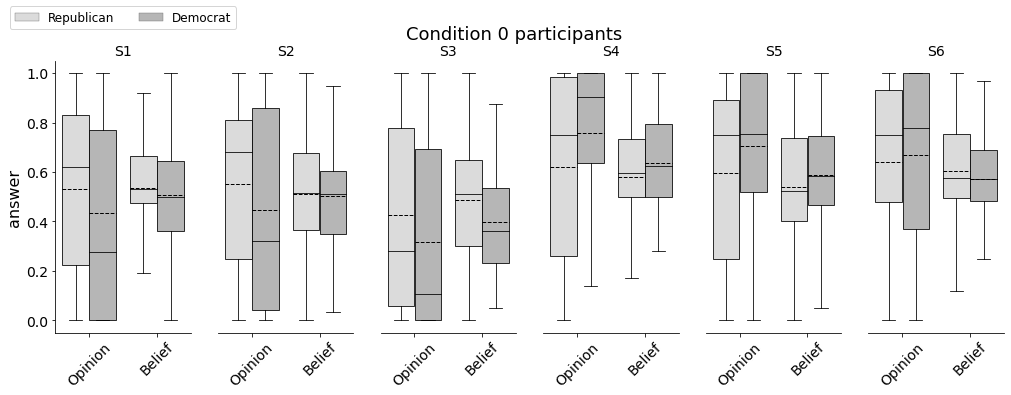

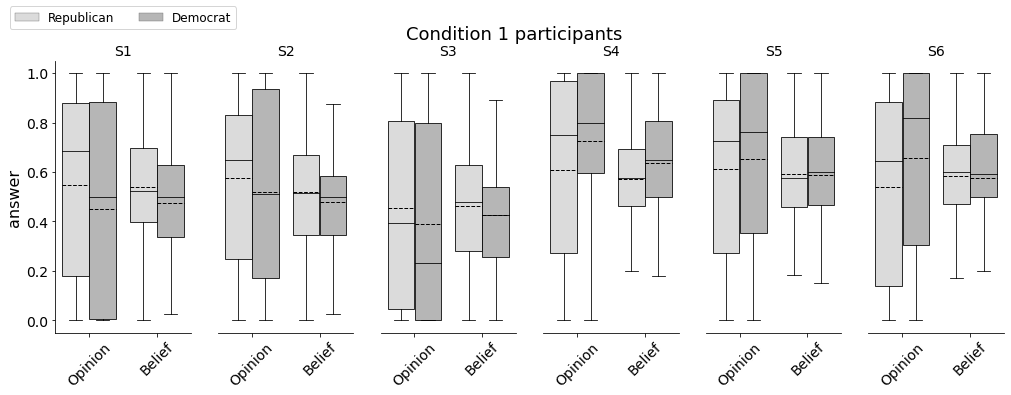

In [117]:
for condition in [0,1]:
    fig, axes = plt.subplots(ncols=6, sharex=True, sharey=True, figsize=(17,5))
    for ax, (n,grp) in zip(axes, temp[temp.Condition==condition].groupby("Statement")):
        sns.boxplot(x="Task", y="value", hue="polAffil", 
                    data=grp, 
                    ax=ax,
                    showfliers=False,
                    showmeans=True,
                    meanline=True,
                    meanprops=meanlineprops,
                    **BOXPROPS2)
        
        ax.set_title(n)
        
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set(ylabel = "answer")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    axes[1].spines['left'].set_visible(False)
    axes[2].spines['left'].set_visible(False)
    axes[3].spines['left'].set_visible(False)
    axes[4].spines['left'].set_visible(False)
    axes[5].spines['left'].set_visible(False)
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    axes[2].get_legend().remove()
    axes[3].get_legend().remove()
    axes[4].get_legend().remove()
    axes[5].get_legend().remove()
    axes[1].get_yaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)
    axes[3].get_yaxis().set_visible(False)
    axes[4].get_yaxis().set_visible(False)
    axes[5].get_yaxis().set_visible(False)
    axes[0].set_xlabel("")
    axes[1].set_xlabel("")
    axes[2].set_xlabel("")
    axes[3].set_xlabel("")
    axes[4].set_xlabel("")
    axes[5].set_xlabel("")
    plt.legend(bbox_to_anchor=(-5.5, 1.2), loc="upper center", borderaxespad=0.,frameon=True,ncol=2);
    fig.suptitle("Condition "+str(condition)+" participants")
    #plt.savefig("boxplotC{}.pdf".format(condition),bbox_inches='tight')

# Boxplots for collected sentences

In [54]:


demargs = pd.melt(data, id_vars=["ID","polAffil","educ","gender","age","polAlign_1"],value_vars=['Q4_1','Q5_1','Q6_1'])
repargs = pd.melt(data, id_vars=["ID","polAffil","educ","gender","age","polAlign_1"],value_vars=['Q1_1', 'Q2_1', 'Q3_1'])

demargs_midpoint_condition1 = pd.melt(data[data.Condition==1], id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q4_midpoint','Q5_midpoint','Q6_midpoint'])
repargs_midpoint_condition1 = pd.melt(data[data.Condition==1], id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q1_midpoint', 'Q2_midpoint', 'Q3_midpoint'])

demargs_midpoint_condition0 = pd.melt(data[data.Condition==0], id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q4_midpoint','Q5_midpoint','Q6_midpoint'])
repargs_midpoint_condition0 = pd.melt(data[data.Condition==0], id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q1_midpoint', 'Q2_midpoint', 'Q3_midpoint'])

In [33]:
demargs

,ID,polAffil,educ,gender,age,polAlign_1,variable,value
0,0,Republican,"Bachelor's degree (For example: BA, AB, BS)",Male,34.0,6.0,Q4_1,1.00
1,1,Republican,"Bachelor's degree (For example: BA, AB, BS)",Female,69.0,10.0,Q4_1,0.77
2,2,Republican,"Professional School Degree (For example: MD,DD...",Female,26.0,9.0,Q4_1,0.77
3,3,Republican,"Bachelor's degree (For example: BA, AB, BS)",Female,46.0,10.0,Q4_1,0.31
4,4,Republican,"Bachelor's degree (For example: BA, AB, BS)",Female,35.0,8.0,Q4_1,0.81
...,...,...,...,...,...,...,...,...
3775,1255,Democrat,"Professional School Degree (For example: MD,DD...",Female,32.0,2.0,Q6_1,0.80
3776,1256,Democrat,"Professional School Degree (For example: MD,DD...",Male,60.0,8.0,Q6_1,0.25
3777,1257,Democrat,"Doctorate degree (For example: PhD, EdD)",Male,64.0,0.0,Q6_1,1.00
3778,1258,Democrat,HIGH SCHOOL GRADUATE – high school DIPLOMA or ...,Male,52.0,5.0,Q6_1,0.01


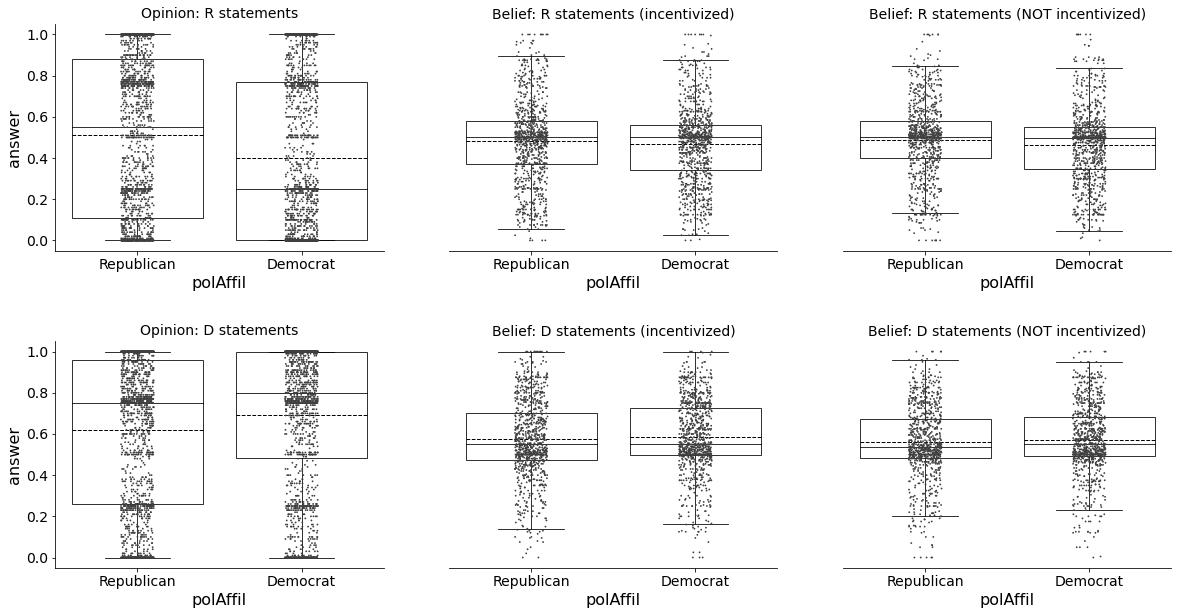

In [34]:
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=12) 
plt.rc('figure', titlesize=18)

fig, ax = plt.subplots(2,3, figsize=(20,10),sharey=True)



sns.boxplot(x="polAffil", y="value", data=repargs, showfliers = False,ax=ax[0,0],showmeans=True,meanline=True,meanprops=meanlineprops,**BOXPROPS)
sns.stripplot(x="polAffil", y="value", data=repargs, color=".25",size=1.8,ax=ax[0,0])
ax[0,0].set_title("Opinion: R statements")
ax[0,0].set(ylabel = "answer")

sns.boxplot(x="polAffil", y="value", data=repargs_midpoint_condition1, showfliers = False,ax=ax[0,1],showmeans=True,meanline=True,meanprops=meanlineprops,**BOXPROPS)
sns.stripplot(x="polAffil", y="value", data=repargs_midpoint_condition1, color=".25",size=1.8,ax=ax[0,1])
ax[0,1].set_title("Belief: R statements (incentivized)")
ax[0,1].set(ylabel = "")
ax[0,1].spines['left'].set_visible(False)
ax[0,1].get_yaxis().set_visible(False)

sns.boxplot(x="polAffil", y="value", data=repargs_midpoint_condition0, showfliers = False,ax=ax[0,2],showmeans=True,meanline=True,meanprops=meanlineprops,**BOXPROPS)
sns.stripplot(x="polAffil", y="value", data=repargs_midpoint_condition0, color=".25",size=1.8,ax=ax[0,2])
ax[0,2].set_title("Belief: R statements (NOT incentivized)")
ax[0,2].set(ylabel = "")
ax[0,2].spines['left'].set_visible(False)
ax[0,2].get_yaxis().set_visible(False)

sns.boxplot(x="polAffil", y="value", data=demargs, showfliers = False,ax=ax[1,0],showmeans=True,meanline=True,meanprops=meanlineprops,**BOXPROPS)
sns.stripplot(x="polAffil", y="value", data=demargs, color=".25",size=1.8,ax=ax[1,0])
ax[1,0].set_title("Opinion: D statements")
ax[1,0].set(ylabel = "answer")

sns.boxplot(x="polAffil", y="value", data=demargs_midpoint_condition1, showfliers = False,ax=ax[1,1],showmeans=True,meanline=True,meanprops=meanlineprops,**BOXPROPS)
sns.stripplot(x="polAffil", y="value", data=demargs_midpoint_condition1, color=".25",size=1.8,ax=ax[1,1])
ax[1,1].set_title("Belief: D statements (incentivized)")
ax[1,1].set(ylabel = "")
ax[1,1].spines['left'].set_visible(False)
ax[1,1].get_yaxis().set_visible(False)

sns.boxplot(x="polAffil", y="value", data=demargs_midpoint_condition0, showfliers = False,ax=ax[1,2],showmeans=True,meanline=True,meanprops=meanlineprops,**BOXPROPS)
sns.stripplot(x="polAffil", y="value", data=demargs_midpoint_condition0, color=".25",size=1.8,ax=ax[1,2])
ax[1,2].set_title("Belief: D statements (NOT incentivized)");
ax[1,2].set(ylabel = "")
ax[1,2].spines['left'].set_visible(False)
ax[1,2].get_yaxis().set_visible(False)

for ax_curr in ax.flatten():
        ax_curr.spines['right'].set_visible(False)
        ax_curr.spines['top'].set_visible(False)



plt.subplots_adjust(hspace=0.4)

#plt.savefig("boxplottogether.pdf",bbox_inches='tight')


In [35]:
print(data[data.polAffil=="Republican"].polAlign_1.mean())
print(data[data.polAffil=="Republican"].polAlign_1.var())
print(data[data.polAffil=="Republican"].polAlign_1.std())

7.630048465266559
3.100778476611718
1.7609027447907843


In [36]:
print(data[data.polAffil=="Democrat"].polAlign_1.mean())
print(data[data.polAffil=="Democrat"].polAlign_1.var())
print(data[data.polAffil=="Democrat"].polAlign_1.std())

1.783151326053042
2.8482156786271453
1.6876657484902469


Democrats are more left-wing than Republicans are right-wing (on 10-point scale).

# Linear Mixed Effects Models

Go to the end to see a table of results.

In [75]:
demargs = pd.melt(data, id_vars=["ID","polAffil","educ","gender","age","polAlign_1"],value_vars=['Q4_1','Q5_1'])
repargs = pd.melt(data, id_vars=["ID","polAffil","educ","gender","age","polAlign_1"],value_vars=['Q1_1', 'Q2_1'])

demargs_midpoint_condition1 = pd.melt(data[data.Condition==1], id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q4_midpoint','Q5_midpoint'])
repargs_midpoint_condition1 = pd.melt(data[data.Condition==1], id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q1_midpoint', 'Q2_midpoint'])

demargs_midpoint_condition0 = pd.melt(data[data.Condition==0], id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q4_midpoint','Q5_midpoint'])
repargs_midpoint_condition0 = pd.melt(data[data.Condition==0], id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q1_midpoint', 'Q2_midpoint'])

demargs_midpoint_ = pd.melt(data, id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q4_midpoint','Q5_midpoint'])
repargs_midpoint_ = pd.melt(data, id_vars=["ID","polAffil","educ","gender","age"],value_vars=['Q1_midpoint', 'Q2_midpoint'])

In [56]:
Dstatements = {}
Rstatements = {}

### Models for the three Democrat arguments 

#### First task (own opinion) 

In [57]:
# Task 1
model = smf.mixedlm("value ~ C(polAffil)",
                    demargs,groups=demargs["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                 MixedLM     Dependent Variable:     value    
No. Observations:      2520        Method:                 REML     
No. Groups:            1260        Scale:                  0.0780   
Min. group size:       2           Log-Likelihood:         -769.4378
Max. group size:       2           Converged:              Yes      
Mean group size:       2.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.719    0.011 67.045 0.000  0.698  0.740
C(polAffil)[T.Republican] -0.099    0.015 -6.484 0.000 -0.129 -0.069
Group Var                  0.035    0.015                           
====================================================================

"""

In [58]:
Dstatements["Opinion ~ Republican"] = res.pvalues["C(polAffil)[T.Republican]"]

In [59]:
model = smf.mixedlm("value~ C(polAffil)+C(gender)",
                    demargs,groups=demargs["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                      MixedLM         Dependent Variable:         value    
No. Observations:           2520            Method:                     REML     
No. Groups:                 1260            Scale:                      0.0780   
Min. group size:            2               Log-Likelihood:             -773.8527
Max. group size:            2               Converged:                  Yes      
Mean group size:            2.0                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.711    0.013 53.311 0.000  0.685  0.737
C(polAffil)[T.Republican]              -0.100    0.015 -6.471 0.000 -0.130 -0.070
C(gender)[T.Male]                       0.018    0.015  1.154 0.248 -0.012  0.048
C(gender)[T.Non-binary / third gender] -0.021    0.064 -0.324 0.746 -0.146  0.104
C(gender)[T.Prefer not to say]          0.214    0.272  0.787 0.431 -0.319  0.747
Group Var                               0.035    0.015                           
=================================================================================

"""

In [60]:
model = smf.mixedlm("value~ C(polAffil)+age",
                    demargs,groups=demargs["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                 MixedLM     Dependent Variable:     value    
No. Observations:      2520        Method:                 REML     
No. Groups:            1260        Scale:                  0.0780   
Min. group size:       2           Log-Likelihood:         -775.8776
Max. group size:       2           Converged:              Yes      
Mean group size:       2.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.731    0.023 31.896 0.000  0.686  0.776
C(polAffil)[T.Republican] -0.098    0.015 -6.393 0.000 -0.129 -0.068
age                       -0.000    0.001 -0.575 0.566 -0.001  0.001
Group Var                  0.035    0.015                           
====================================================================

"""

In [62]:
model = smf.mixedlm("value~ C(polAffil)+C(educ)",
                    demargs,groups=demargs["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Mixed Linear Model Regression Results
=====================================================================================================================================
Model:                                      MixedLM                           Dependent Variable:                           value    
No. Observations:                           2520                              Method:                                       REML     
No. Groups:                                 1260                              Scale:                                        0.0780   
Min. group size:                            2                                 Log-Likelihood:                               -781.1059
Max. group size:                            2                                 Converged:                                    Yes      
Mean group size:                            2.0                                                                                      
-------------------------------------------------------------------------------------------------------------------------------------
                                                                                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                   0.450    0.192  2.349 0.019  0.075  0.826
C(polAffil)[T.Republican]                                                                  -0.096    0.015 -6.230 0.000 -0.126 -0.066
C(educ)[T.12th grade NO DIPLOMA]                                                            0.085    0.247  0.344 0.731 -0.400  0.570
C(educ)[T.7th or 8th grade]                                                                 0.288    0.271  1.061 0.289 -0.244  0.819
C(educ)[T.Associate degree in college - Academic program]                                   0.238    0.194  1.227 0.220 -0.142  0.618
C(educ)[T.Associate degree in college - Occupational/vocational program]                    0.284    0.195  1.452 0.147 -0.099  0.667
C(educ)[T.Bachelor's degree (For example: BA, AB, BS)]                                      0.260    0.192  1.354 0.176 -0.116  0.636
C(educ)[T.Doctorate degree (For example: PhD, EdD)]                                         0.418    0.206  2.031 0.042  0.015  0.821
C(educ)[T.HIGH SCHOOL GRADUATE – high school DIPLOMA or the equivalent (For example: GED)]  0.236    0.193  1.222 0.222 -0.142  0.613
C(educ)[T.Master's degree (For example: MA, MS, MEng, MEd, MSW, MBA)]                       0.313    0.193  1.622 0.105 -0.065  0.690
C(educ)[T.Professional School Degree (For example: MD,DDS,DVM,LLB,JD)]                      0.261    0.199  1.312 0.189 -0.129  0.652
C(educ)[T.Some college but no degree]                                                       0.273    0.192  1.420 0.156 -0.104  0.650
Group Var                                                                                   0.034    0.015                           
=====================================================================================================================================

"""

In [63]:
model = smf.mixedlm("value ~ polAlign_1",
                    demargs,groups=demargs["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: value    
No. Observations: 2520    Method:             REML     
No. Groups:       1260    Scale:              0.0780   
Min. group size:  2       Log-Likelihood:     -771.2450
Max. group size:  2       Converged:          Yes      
Mean group size:  2.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.739    0.013 56.868 0.000  0.713  0.764
polAlign_1   -0.015    0.002 -6.501 0.000 -0.019 -0.010
Group Var     0.035    0.015                           
=======================================================

"""

#### Second task all conditions 

In [79]:
model = smf.mixedlm("value~ C(polAffil)",
                    demargs_midpoint_,groups=demargs_midpoint_["ID"])
res = model.fit()
res.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM      Dependent Variable:      value   
No. Observations:      2520         Method:                  REML    
No. Groups:            1260         Scale:                   0.0184  
Min. group size:       2            Log-Likelihood:          932.8015
Max. group size:       2            Converged:               Yes     
Mean group size:       2.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  0.585    0.006 102.340 0.000  0.574  0.597
C(polAffil)[T.Republican] -0.023    0.008  -2.850 0.004 -0.039 -0.007
Group Var                  0.012    0.009                            
=====================================================================

"""

In [80]:
Dstatements["Belief ~ Republican"] = res.pvalues["C(polAffil)[T.Republican]"]

#### Second task condition 1 (belief elicitation with incentives) 

In [64]:
# Task 2 condition 1 (incentivized)
model = smf.mixedlm("value~ C(polAffil)",
                    demargs_midpoint_condition1,groups=demargs_midpoint_condition1["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                  MixedLM     Dependent Variable:     value   
No. Observations:       1288        Method:                 REML    
No. Groups:             644         Scale:                  0.0186  
Min. group size:        2           Log-Likelihood:         453.3400
Max. group size:        2           Converged:              Yes     
Mean group size:        2.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.592    0.008 71.743 0.000  0.576  0.608
C(polAffil)[T.Republican] -0.021    0.012 -1.811 0.070 -0.044  0.002
Group Var                  0.013    0.013                           
====================================================================

"""

In [65]:
Dstatements["Belief C1 ~ Republican"] = res.pvalues["C(polAffil)[T.Republican]"]

#### Second task condition 0 (belief elicitation without incentives) 

In [66]:
# Task 2 condition 0 (not incentivized)
model = smf.mixedlm("value~ C(polAffil)",
                    demargs_midpoint_condition0,groups=demargs_midpoint_condition0["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                  MixedLM     Dependent Variable:     value   
No. Observations:       1232        Method:                 REML    
No. Groups:             616         Scale:                  0.0182  
Min. group size:        2           Log-Likelihood:         475.2254
Max. group size:        2           Converged:              Yes     
Mean group size:        2.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.579    0.008 73.257 0.000  0.563  0.594
C(polAffil)[T.Republican] -0.026    0.011 -2.265 0.024 -0.048 -0.003
Group Var                  0.011    0.012                           
====================================================================

"""

In [67]:
Dstatements["Belief C0 ~ Republican"] = res.pvalues["C(polAffil)[T.Republican]"]

### Models for the three Republican arguments 

#### First task (own opinion) 

In [68]:
model = smf.mixedlm("value~ C(polAffil)",
                    repargs,groups=repargs["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:                MixedLM     Dependent Variable:     value    
No. Observations:     2520        Method:                 REML     
No. Groups:           1260        Scale:                  0.0740   
Min. group size:      2           Log-Likelihood:         -991.2924
Max. group size:      2           Converged:              Yes      
Mean group size:      2.0                                          
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.443    0.013 33.748 0.000  0.418  0.469
C(polAffil)[T.Republican] 0.119    0.019  6.364 0.000  0.083  0.156
Group Var                 0.074    0.023                           
===================================================================

"""

In [69]:
Rstatements["Opinion ~ Republican"] = res.pvalues["C(polAffil)[T.Republican]"]

#### Second task all conditions 

In [81]:
model = smf.mixedlm("value~ C(polAffil)",
                    repargs_midpoint_,groups=repargs_midpoint_["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM     Dependent Variable:     value   
No. Observations:      2520        Method:                 REML    
No. Groups:            1260        Scale:                  0.0174  
Min. group size:       2           Log-Likelihood:         858.4733
Max. group size:       2           Converged:              Yes     
Mean group size:       2.0                                         
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.483    0.006 77.538 0.000  0.471  0.495
C(polAffil)[T.Republican] 0.022    0.009  2.447 0.014  0.004  0.039
Group Var                 0.016    0.011                           
===================================================================

"""

In [82]:
Rstatements["Belief ~ Republican"] = res.pvalues["C(polAffil)[T.Republican]"]

#### Second task condition 1 (belief elicitation with incentives) 

In [70]:
# Task 2 condition 1 (incentivized)
model = smf.mixedlm("value~ C(polAffil)",
                    repargs_midpoint_condition1,groups=repargs_midpoint_condition1["ID"])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM     Dependent Variable:     value   
No. Observations:      1288        Method:                 REML    
No. Groups:            644         Scale:                  0.0179  
Min. group size:       2           Log-Likelihood:         396.9905
Max. group size:       2           Converged:              Yes     
Mean group size:       2.0                                         
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.483    0.009 52.632 0.000  0.465  0.501
C(polAffil)[T.Republican] 0.021    0.013  1.626 0.104 -0.004  0.047
Group Var                 0.018    0.016                           
===================================================================

"""

In [71]:
Rstatements["Belief C1 ~ Republican"] = res.pvalues["C(polAffil)[T.Republican]"]

#### Second task condition 0 (belief elicitation without incentives) 

In [72]:
# Task 2 condition 0 (not incentivized)
model = smf.mixedlm("value~ C(polAffil)",
                    repargs_midpoint_condition0,groups=repargs_midpoint_condition0["ID"])
res = model.fit()
res.summary()


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:                 MixedLM     Dependent Variable:     value   
No. Observations:      1232        Method:                 REML    
No. Groups:            616         Scale:                  0.0169  
Min. group size:       2           Log-Likelihood:         457.9223
Max. group size:       2           Converged:              Yes     
Mean group size:       2.0                                         
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.484    0.008 57.429 0.000  0.467  0.500
C(polAffil)[T.Republican] 0.022    0.012  1.853 0.064 -0.001  0.046
Group Var                 0.014    0.014                           
===================================================================

"""

In [73]:
Rstatements["Belief C0 ~ Republican"] = res.pvalues["C(polAffil)[T.Republican]"]

## LMM results table 

In [83]:
LMM_results = []
LMM_results.append(Dstatements)
LMM_results.append(Rstatements)
temp = pd.DataFrame(LMM_results)
temp = temp.transpose(copy=True)
temp.columns = ["D statements", "R statments"]
temp

,D statements,R statments
Opinion ~ Republican,8.915643e-11,1.969495e-10
Belief C1 ~ Republican,7.011850e-02,1.038454e-01
Belief C0 ~ Republican,2.352479e-02,6.388095e-02
Belief ~ Republican,4.374150e-03,1.441790e-02


# Exploratory analysis

### PCA

In [55]:
from sklearn.preprocessing import normalize
import math


def plotpca(X,pols):    

    normed = X.div(X.sum(axis=1), axis=0).dropna() 
    
    
    pca = PCA(n_components=2)
    trans_X = pca.fit_transform(normed)
    principalDf = pd.DataFrame(data = trans_X
                 , columns = ['principal component 1', 'principal component 2'])
    principalDf["pol"] = pols


    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(1,1,1) 
    targets = ["Republican", "Democrat"]
    colors = ['r', 'b',]
    for target, color in zip(targets,colors):
        indicesToKeep = principalDf['pol'] == target
        ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1'], 
                   principalDf.loc[indicesToKeep, 'principal component 2'], 
                   c = color, s = 20)
    ax.legend(targets)

    print(pca.explained_variance_ratio_)
    pca_values=pca.components_


    colors = plt.cm.gray(np.linspace(0.1,0.6,14))
    columns=X.columns.values

    plt.figure(figsize=(10,10))

    add_string=""
    for i in range(len(pca_values[0])):
        xi=pca_values[0][i]*0.5
        #print(xi)
        yi=pca_values[1][i]*0.5
        ax.arrow(0,0, 
                  dx=xi, dy=yi, 
                  head_width=0.01, head_length=0.01, 
                  color=colors[i], length_includes_head=True)  
        #add_string=f" ({round(xi,2)} {round(yi,2)})"
        ax.text(xi, 
                 yi, 
                 #s=columns[i] + add_string,fontsize=12)
                 s=columns[i],fontsize=12)

[0.45247835 0.23643947]


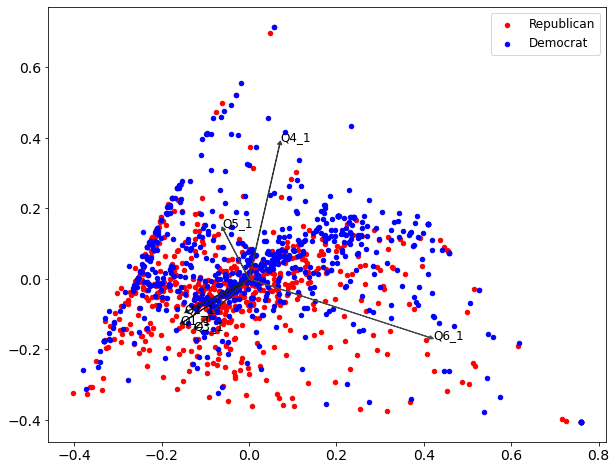

<Figure size 720x720 with 0 Axes>

In [58]:
pols = data["polAffil"]
X = data[firsttask_columns]
plotpca(X,pols)

[0.4189368 0.2423868]


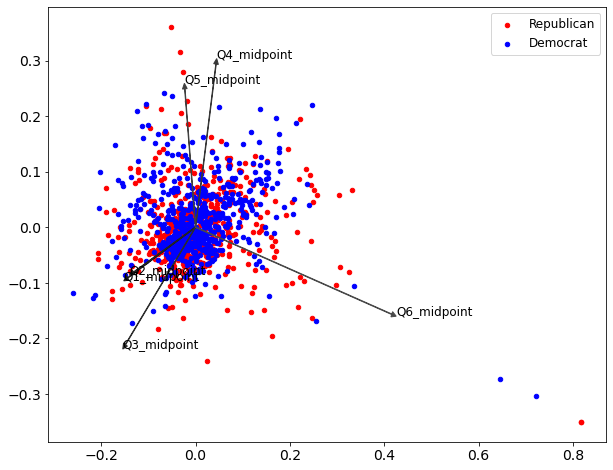

<Figure size 720x720 with 0 Axes>

In [59]:
pols = data["polAffil"]
X = data[midpoint_columns]
plotpca(X,pols)